# Tutorial: graph cuts and clustering

$\newcommand{\ones}{\mathbf{1}}
\newcommand{\reals}{\mathbf{R}}
\newcommand{\symm}{\mathbf{S}}
\newcommand{\diag}{\mathbf{diag}}
\newcommand{\Tr}{\mathbf{tr}}$



## Introduction

Let $G = (V,E)$ be an undirected graph with vertex set $V = {1,\ldots,n}$ and edge set $E$, i.e., $(i,j) \in E$ if there is an edge between vertices $i$ and $j$ ($i \neq j$). The symmetric matrix $W\in\symm^n$ is a weighted adjacency matrix for the graph $G$ such that $W_{ij}$ is a nonnegative weight associated with the edge $(i,j)$. 

A cut of a graph is a partition of its vertices into two disjoint subsets. An edge is said to be crossing a cut if it goes from one vertex subset to the other, and the weight of a cut is the sum the weights of all edges that cross the cut. (For an unweighted graph, the weight of a cut is also referred to as the size of the cut, and for weighted graphs, the cut weight is sometimes referred to as its value.) If we let $x_i \in  \{-1,+1\}$ represent the label of the $i$th vertex, the weight of the cut represented by $x = (x_1,\ldots,x_n)$ can be expressed as
\begin{align*}
    f(x) = \frac12 \sum_{(i,j) \in E} W_{ij}(1-x_ix_j) = \frac14( \ones^TW\ones-  x^TWx).
\end{align*}

- (symmetric) graph Laplacian $L = D - W$ where $D = \diag(W\ones)$ is the (weighted) degree matrix.
- normalized graph Laplacian $\bar L = D^{-1/2}LD^{-1/2} = I -  D^{-1/2}WD^{-1/2}$

Properties of the graph Laplacian:
- $L$ is positive semidefinite (it is diagonally dominant by construction)
- $L\ones = 0$ which implies that $\ones$ belongs to the nullspace of $L$
- the algebraic multiplicity of $\lambda_{\min} = 0$ is equal to the number of connected components
- the second-smallest eigenvalue of $L$ is the so-called *algebraic connectivity* (also known as the *Fiedler value*), and the associated eigenvector is called the *Fiedler vector*

Note that the diagonal of $W$ is zero, but $f(x)$ is invariant with respect to the diagonal entries of $W$ over the set $\mathcal X =\{x \in \reals^n \,|\, x_i^2 = 1, i=1,\ldots,n\}$, so minimizing/maximizing $f(x)$ is equivalent to minimizing/maximizing
$ x^T(D-W)x$ over the set $\mathcal X$ for any diagonal matrix $D$.

### Maximum cut

A maximum cut can obtained by maximizing $f(x)$ which is equivalent to the problem
\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & -x^TWx \\
    \mbox{subject to} & x_i^2 = 1, \ i=1,\ldots,n.
    \end{array}
\end{align*}
If we let $X = xx^T$, we obtain an equivalent problem
\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & -\Tr(WX) \\
    \mbox{subject to} & X_{ii} = 1, \ i=1,\ldots,n\\
                      & X = xx^T
    \end{array}
\end{align*}
where the only nonconvex constraint is the rank-1 constraint $X = xx^T$.

- semidefinite relaxation by [Goemans & Williamson (1995)](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf)

### Minimum cut

Can be solved by solving $n-1$ minimum $s$-$t$-cut problems (fix $s$ and solve $n-1$ max-flow-min-cut problems).

References:

- [A simple min-cut algorithm](https://doi.org/10.1145/263867.263872)
- Max-flow-min-cut theorem (Ford & Fulkerson, 1956)
- [Ford–Fulkerson algorithm](https://en.wikipedia.org/wiki/Ford–Fulkerson_algorithm), [Edmonds–Karp algorithm](https://en.wikipedia.org/wiki/Edmonds–Karp_algorithm)


### Minimum balanced cut

The minimum balanced cut problem can be expressed as  
\begin{align*}
\begin{array}{ll}
\mbox{minimize} & -x^TWx\\
\mbox{subject to} & (\ones^Tx)^2 \leq \delta^2 \\
    & x_i^2 = 1, \ i=1,\ldots,n
\end{array}
\end{align*}
with parameter $\delta \geq 0$ and variable $x \in \reals^n$. The parameter $\delta$ can be used to balance the cardinality of the subsets induced by a cut. For example, letting $\delta = 1$ implies that $|\ones^Tx| \leq 1$, and hence the cardinality of the two subsets can differ by at most 1. (Note that $\delta = 0$ results in an infeasible problem if $n$ is odd.) Furthermore, since $|\ones^Tx| \leq n$ for all feasible $x$, the minimum balanced cut problem is equivalent to the minimum cut problem if $\delta \geq n$.

Finally, we mention that the minimum balanced cut problem is equivalent to the problem
\begin{align*}
\begin{array}{ll}
    \mbox{minimize} & x^T(\gamma \ones\ones^T - W)x \\
    \mbox{subject to} & x_i^2 =1, \ i=1,\ldots,n
\end{array}
\end{align*}
for some nonnegative parameter $\gamma$.

### Spectral clustering

The (basic) spectral clustering problem can be formulated as

\begin{align*}
\begin{array}{ll}
\mbox{minimize} & x^TLx \\
\mbox{subject to} & \ones^Tx = 0 \\
                  & \|x\|_2 = 1.
\end{array}
\end{align*}

For a connected graph, the Fiedler vector is a solution to the above problem: $\ones$ is in the nullspace of $L$, and since the feasible set $\{x\,|\, \|x\|_2 = 1, \ones^Tx = 0\}$ is the set of unit vectors in the range of $L$ (the orthogonal complement of the nullspace), the eigenvector associated with the second-smallest eigenvalue minimizes $x^TLx$.


## Numerical experiments

In [1]:
%matplotlib inline
import matplotlib, matplotlib.pyplot as plt
from cvxopt import solvers, matrix, spmatrix, sparse, msk, blas, lapack, normal, amd, mul, misc
import sklearn, numpy as np
from sklearn import datasets, neighbors, cluster
from math import sqrt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10,6)

We start by generating an example based on the "two moons" toy dataset.

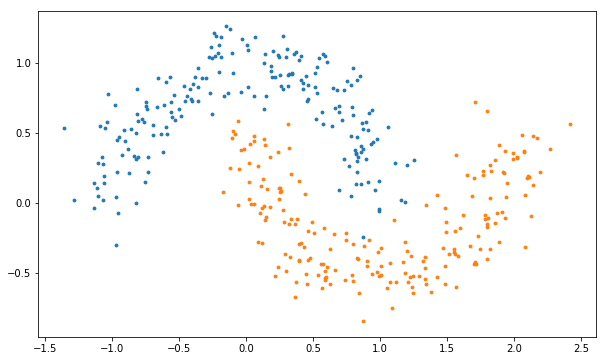

In [15]:
K = 2    # Number of classes
N = 400  # Number of points
X,y = datasets.make_moons(N, noise = 0.15)
for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], s=8, color="C"+str(k))

## K-means clustering

Applying the K-means algorithm yields the following clusters:

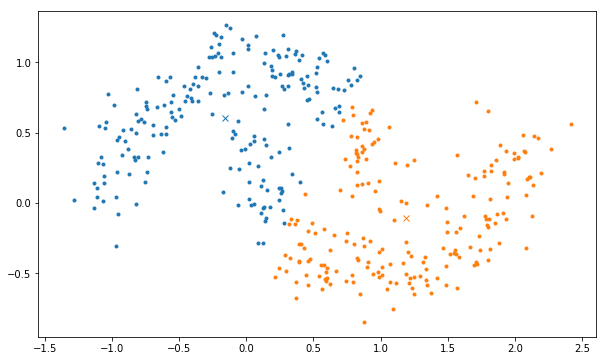

In [16]:
cnt, lbl1, iner = cluster.k_means(X, K)
for k in range(K):
    plt.plot(X[lbl1==k,0], X[lbl1==k,1], marker='.', color="C"+str(k), lw=0)
    plt.plot(cnt[k,0], cnt[k,1], marker='x', color="C"+str(k), lw=0)

## Spectral clustering

We now generate an affinity matrix for a neighbor graph (two points are neighbors if the distance between the two points is at most $R$).

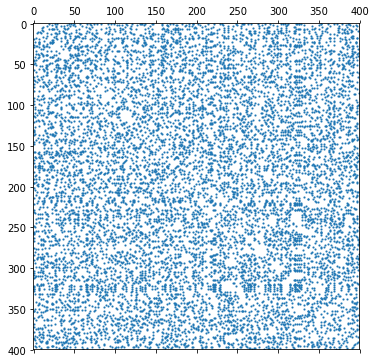

In [17]:
# Neighbor adjacency matrix
R = 0.3
#A = sklearn.neighbors.radius_neighbors_graph(X, R, mode='connectivity')  # unweighted adjacency matrix
A = sklearn.neighbors.radius_neighbors_graph(X, R, mode='distance')      # weighted adjacency matrix
plt.spy(A, ms=1);

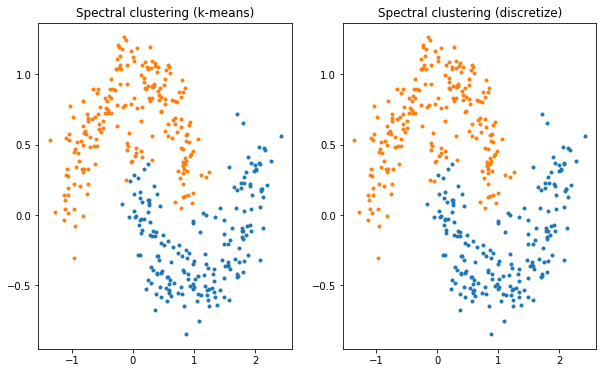

In [18]:
lbl2 = cluster.spectral_clustering(A,K,assign_labels='kmeans')
lbl3 = cluster.spectral_clustering(A,K,assign_labels='discretize')

plt.subplot(121)
for k in range(K):
    plt.plot(X[lbl2==k,0], X[lbl2==k,1], marker='.', color="C"+str(k), lw=0)
plt.title('Spectral clustering (k-means)')

plt.subplot(122)
for k in range(K):
    plt.plot(X[lbl3==k,0], X[lbl3==k,1], marker='.', color="C"+str(k), lw=0)
plt.title('Spectral clustering (discretize)');

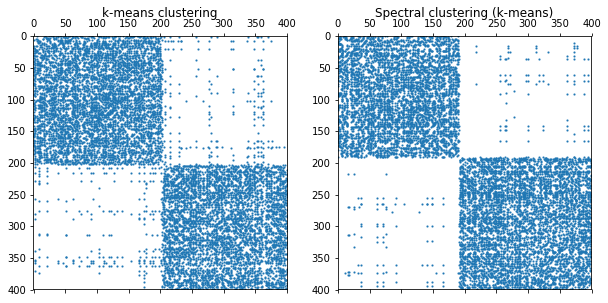

In [19]:
idx1 = lbl1.argsort()
idx2 = lbl2.argsort()
plt.subplot(1,2,1)
plt.spy(A[np.ix_(idx1,idx1)],ms=1);
plt.title('k-means clustering')
plt.subplot(1,2,2)
plt.spy(A[np.ix_(idx2,idx2)],ms=1);
plt.title('Spectral clustering (k-means)');

## Balanced Cuts

We now solve the semidefinite relaxation of the balance-constrained minimum cut problem. 

In [20]:
def custom_kkt(W):
    """
    Custom KKT solver for the following conic LP
    formulation of the Schur relaxation of the
    balance-constrained min/max cut problem
    
        maximize     Tr(C,X)
        subject to 
            X_{ii} = 1, i=1...n
            sum(X) + x = const
            x >= 0, X psd
    """
    
    r = W['rti'][0]
    N = r.size[0]
    e = matrix(1.0,(N,1))
    
    # Form and factorize reduced KKT system
    H = matrix(0.0,(N+1,N+1))
    blas.syrk(r,H,n=N,ldC=N+1)    
    blas.symv(H,e,H,n=N,ldA=N+1,offsety=N,incy=N+1)    
    H[N,N] = blas.dot(H,e,n=N,offsetx=N,incx=N+1)
    rr = H[:N,:N]    # Extract and symmetrize (1,1) block
    misc.symm(rr,N)  # 
    q = H[N,:N].T    # Extract q = rr*e
    H = mul(H,H)
    H[N,N] += W['di'][0]**2
    lapack.potrf(H)
    
    def fsolve(x,y,z):
        """
        Solves the system of equations

            [ 0  G'*W^{-1} ] [ ux ] = [ bx ]
            [ G  -W'       ] [ uz ]   [ bz ]
        
        """
        #  Compute bx := bx + G'*W^{-1}*W^{-T}*bz
        v = matrix(0.,(N,1))
        for i in range(N):
            blas.symv(z,rr,v,ldA=N,offsetA=1,n=N, offsetx = N*i)
            x[i] += blas.dot(rr,v,n=N,offsetx=N*i)
        blas.symv(z,q,v,ldA=N,offsetA=1,n=N)
        x[N] += blas.dot(q,v) + z[0]*W['di'][0]**2
        #  Solve G'*W^{-1}*W^{-T}*G*ux = bx
        lapack.potrs(H,x)
        
        # Compute bz := -W^{-T}*(bz-G*ux)        
        # z -= G*x
        z[1::N+1] -= x[:-1]
        z -= x[-1]
        # Apply scaling
        z[0] *= -W['di'][0]
        blas.scal(0.5,z,n=N,offset=1,inc=N+1) 
        tmp = +r
        blas.trmm(z, tmp, ldA=N, offsetA=1, n=N, m=N)
        blas.syr2k(r, tmp, z, trans='T', offsetC=1, ldC=N, n=N, k=N, alpha = -1.0) 
        
    return fsolve

def balanced_cut_conelp(A, delta = 1.0, cut = 'min'):
    """
    Generates problem data for semidefinite relaxation of the 
    following balance-constrained min/max cut problem
        
        min./max.   -Tr(WX) 
        subject to  X{ii} == 1,  i = 1,...,n
                    sum(X) + x == delta^2
                    x >= 0,  X p.s.d.            
    """
    c = matrix([matrix(-1.0,(N,1)), -delta**2])
    h = matrix([0.0, matrix(A.toarray(),(N**2,1))],(N**2+1,1))
    if cut == 'min': 
        blas.scal(-1.0,h)
    elif not cut == 'max':
        raise ValueError('cut must be "min" or "max"')
    G = sparse([[spmatrix(1.0,[1+i*(N+1) for i in range(N)],range(N),(N**2+1,N))],
                [matrix(1.0,(N**2+1,1))]])
    dims = {'l':1,'q':[],'s':[N]}
    return c,G,h,dims

def balanced_cut(A, delta = 1.0, cut = 'min', solver = "conelp_custom"):
    """
    Solves semidefinite relaxation of the following 
    balance-constrained min/max cut problem
    """
    prob = balanced_cut_conelp(A, delta, cut)
    if solver == "mosek":
        sol = msk.conelp(*prob)
        Z = matrix(sol[2][1:],(N,N),tc='d')
    elif solver == "conelp":
        sol = solvers.conelp(*prob)
        Z = matrix(sol['z'][1:],(N,N),tc='d')
    elif solver == "conelp_custom":
        sol = solvers.conelp(*prob, kktsolver=custom_kkt, options = {'refinement':3})
        Z = matrix(sol['z'][1:],(N,N),tc='d')
    else:
        raise ValueError("Unknown solver")
    return Z

def evd(Z, tol=1e-5, maxr=None, scaled=False):
    """
    Computes eigenvalue decomposition of a symmetrix matrix Z
    and returns a matrix Vr with at most 'maxr' eigenvectors and 
    a vector wr with the corresponding eigenvalues. Only eigenvalues 
    that satisfy lambda_i > tol*lambda_max are included.
    """
    Zt = +Z
    N = Z.size[0]
    if maxr is None: maxr = N
    w = matrix(0.0,(N,1))
    V = matrix(0.0,(N,N))
    lapack.syevr(Zt,w,jobz='V',Z=V)
    if scaled:
        Vr = matrix([[V[:,i]*sqrt(w[i])] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    else:
        Vr = matrix([[V[:,i]] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    wr = matrix([w[i] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    return Vr,wr

In [21]:
Z = balanced_cut(A, delta = 1.0, cut = 'min', solver = 'mosek')

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 401             
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 401             
  Cones               

In [22]:
# Compute trunctated EVD
Vr,wr = evd(Z, scaled=True)
print("Eigenvalues: ", list(wr))

Eigenvalues:  [320.8537014260939, 79.14629770085513]


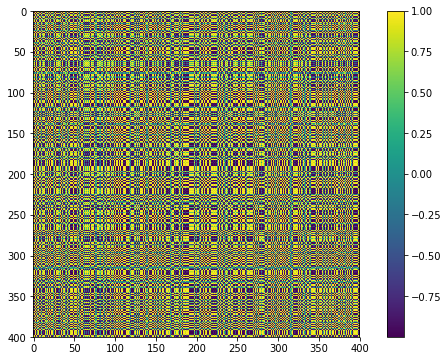

In [23]:
plt.figure()
plt.imshow(Vr*Vr.T)
plt.colorbar()

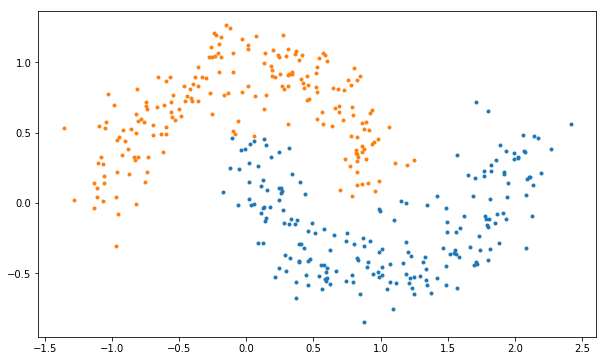

In [24]:
# Assign labels and plot 
x1 = np.array([0 if vi >= 0.0 else 1 for vi in list(Vr[:,0])])
for k in range(K):
    plt.plot(X[x1==k,0], X[x1==k,1], marker='.', color="C"+str(k), lw=0)

In [25]:
# Generate 1000 samples and apply rounding 
Am = matrix(A.toarray())
vals = []
fbest = float('-inf')
xbest = None
for k in range(1000):
    x = matrix([-1. if xi >=0 else 1. for xi in Vr*normal(Vr.size[1],1)])
    f = blas.dot(x,Am*x) 
    if f > fbest:
        fbest = f
        xbest = x
    vals.append(f)
print(fbest)

1899.560752924041


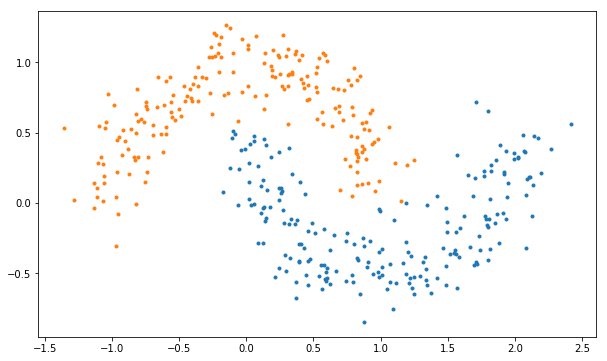

In [26]:
# Assign labels and plot 
x1 = np.array([0 if xi >= 0.0 else 1 for xi in xbest])
for k in range(K):j
    plt.plot(X[x1==k,0], X[x1==k,1], marker='.', color="C"+str(k), lw=0)